## Ejercicios

1. Para los siguientes modelos vistos en los temas anteriores realizá las siguientes pruebas:

a) `cs_nh` una prueba predictiva a priori, todos los grupos juntos

b) `cs_nh` una prueba predictiva a posteriori, todos los grupos juntos

c) `cs_nh` una prueba predictiva a posteriori, los 19 grupos por separado


2) Usando un modelo construido para tus propios datos realizá una prueba predictiva a priori y en función del resultado modificá los priors elegidos.

3) Usando la función `az.plot_bpv` y sobre la distribución a posteriori del modelo `cs_nh` realizá:

a) Un gráfico de los p-valores marginales, para todos los grupos juntos.

b) Un gráfico de los p-valores marginales, para los 19 grupos por separado.

c) Un gráfico de los p-valores para un estadístico a su elección que no sea la media, para los 19 grupos por separado.


4) Para ganar intuición sobre los gráficos de p-valores marginales. Vamos a hacer el siguiente experimento. Vamos a crear 4 InferenceData, todos con el mismo grupo "observed_data" y con 200 observaciones (extra, podés probar cambiar el número de observaciones). 

* Uno de ellos con predicciones que provengan de una distribución más ancha que la observada
* Otro con una predicciones que provengan de una distribución más angosta
* El tercero con la media desplazada respecto de la observada
* El cuarto con muestra de la misma distribución que la observada.

Exlicá las observaciones.

5) (extra) Usando la transformada integral de probabilidad escribí un algoritmo que utilizando una distribución uniforme permita generar muestreas aleatorias de cualquier distribución de probabiliad.

In [23]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz


## Ejercicio 1

### a.

In [2]:
cs_data = pd.read_csv('datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}


Sampling: [y, μ, σ]


In [4]:
#a. prior predictive todos juntos
with pm.Model() as cs_nh_todo_junto:         
    μ = pm.Normal('μ', mu=0, sigma=1) 
    σ = pm.HalfNormal('σ', sigma=2) 
 
    y = pm.Normal('y', mu=μ, sigma=σ, observed=diff) 
     
    idata_todo_junto = pm.sample_prior_predictive(samples=100)

Sampling: [y, μ, σ]


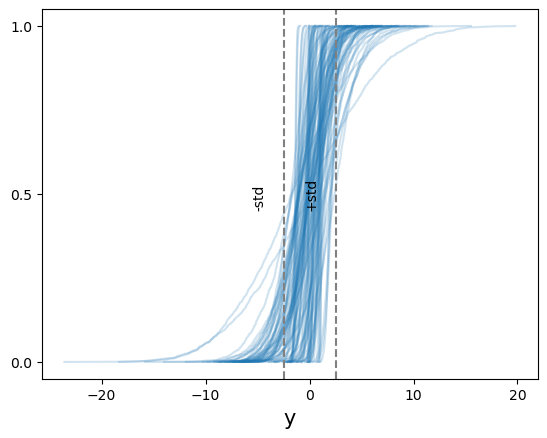

In [7]:

ax = az.plot_ppc(idata_todo_junto, group="prior", kind="cumulative", mean=False, legend=False)

refs = {"+std":2.5,
        "-std":-2.5}

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90)


In [6]:
cs_data[cs_data["aa"]=="ALA"]["theo"].mean()

53.24387323943662

Si entiendo bien, en esta tabla muestra distintos corrimientos quimicos para los aminoacidos que estamos mirando [https://www.researchgate.net/figure/13-C-a-and-13-C-b-chemical-shift-reference-values-for-use-with-the-program-MAPPER-a_tbl1_12227223]

No se la diferencia entre ambos omegas, pero entiendo que nuestros valores son la primera columna (calcule la media para ALA y es mas parecido a esa columna).

Frente a esto, veo que los errores aceptados estan alrededor de 2.5 (masomenos). A partir del grafico del prior predictive, veo que este modelo tira muchas predicciones por fuera de este intervalo (super aproximado)

### b

In [8]:
#b.

with cs_nh_todo_junto:
    idata_todo_junto_posterior = pm.sample(1000, random_seed=1791, progressbar=False)
    idata_todo_junto_posterior.extend(pm.sample_posterior_predictive(idata_todo_junto_posterior, progressbar=False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


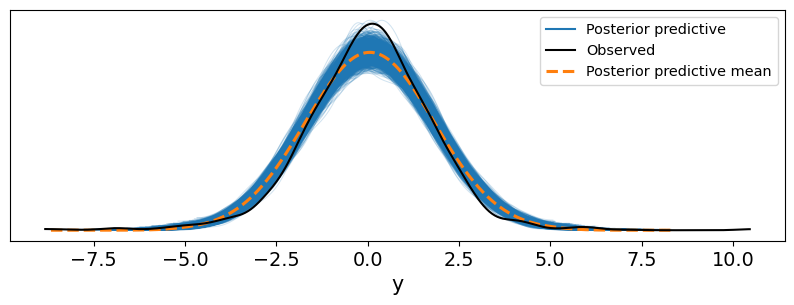

In [9]:
ax = az.plot_ppc(idata_todo_junto_posterior, figsize=(10, 3))


La posterior con los aminoacidos todos juntos sobreestima las diferencias mayores a 2.5, aunque por relativamente poco. Del mismo modo, se queda corto con los valores cercanos a cero (los subestima). A pesar de eso, no parece ser un mal modelo.

### c

In [10]:
#c. Aminoacidos por separado
with pm.Model(coords=coords) as cs_nh_separados:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cat = pm.sample(1000, random_seed=1791, progressbar=False)
    idata_cat.extend(pm.sample_posterior_predictive(idata_cat, progressbar=False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


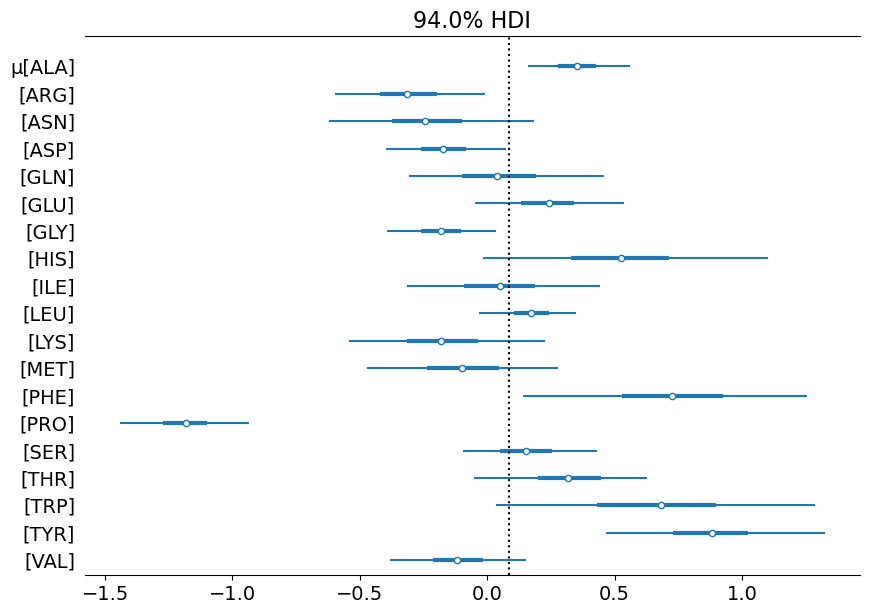

In [11]:
axes = az.plot_forest(idata_cat,
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 7),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cat.posterior['μ'].mean(), *y_lims, color="k", ls=":");

Con el modelo que separa todos los aminoacidos, vemos que para algunos genera mejores predicciones (diferencias mas cercanas a cero), que otros.
Aun asi, las medias de las diferencias estan todas dentro del intervalo (-2.5,2.5), por lo que, en comparacion con la tabla anterior, son modelos que predicen muy bien.

## Ejercicio 2

Tengo datos de telefonos publicados en Amazon. Quiero ver como son las distribuciones de precios para las distintas marcas (como son muchisimas, agarro 4 que tengan la misma cantidad de telefonos en venta).

De todas las columnas, nos importan 2: "brand" (Marca) y "Price (Dolar)" (El precio de venta en dolares)

In [2]:
data_celus = pd.read_csv("datos/Amazon_Cell_Phones.csv")

In [3]:
data_celus["brand"].value_counts().head(10)

brand
SAMSUNG     998
Motorola    228
Apple       202
Xiaomi      147
LG          132
Google      118
Nokia        83
BLU          82
OnePlus      74
Ulefone      51
Name: count, dtype: int64

Por las diferencias en cantidades me quedo con Motorola, Apple, Xiaomi y Google (LG no me gusta)

In [4]:
groups = ["Motorola","Apple","Xiaomi","Google"]
celus_grupos = data_celus.loc[data_celus["brand"].isin(groups),["Price (Dollar)","brand"]]
celus_grupos.dropna(inplace=True)

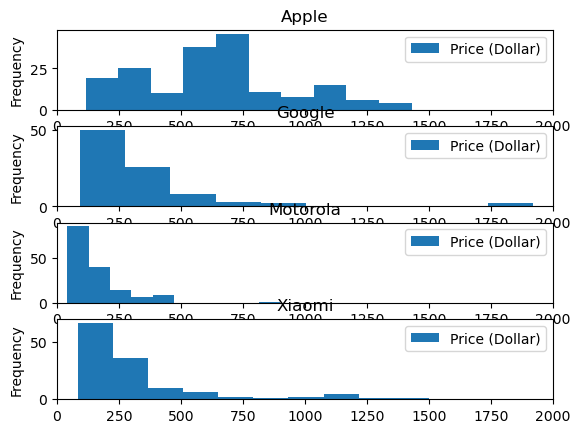

In [9]:
plots = celus_grupos.plot.hist("brand")
for plot in plots:
    plot.set_xlim((0,2000))

Como hay mas telefonos baratos que caros, uso una gamma para el precio.
Como valor de referencia, el ultimo iphone (16), en su gama mas cara (Pro Max) esta 1199usd. Asi que para la media, voy a usar una normal con media 1/2 iphone16ProMax y sigma 1/8 iphone16ProMax; y para la sigma una HalfNormal con sigma 1/4 iphone16ProMax

In [10]:
cat_encode = pd.Categorical(celus_grupos['brand'])
idx = cat_encode.codes
coords = {"brand": cat_encode.categories, "brand_flat":cat_encode.categories[idx]}

valor_referencia = 1199

with pm.Model(coords = coords) as modelo_telefonos:
    mu = pm.Normal("mu",mu=valor_referencia/2,sigma=valor_referencia/8,dims="brand")
    sigma = pm.HalfNormal("sigma",sigma=valor_referencia/4,dims="brand")


    precio = pm.Gamma("precio",mu=mu[idx],sigma=sigma[idx],observed=celus_grupos["Price (Dollar)"],dims="brand_flat")

In [13]:
with modelo_telefonos:
    sampleo = pm.sample_prior_predictive(100)

Sampling: [mu, precio, sigma]


<Axes: xlabel='precio'>

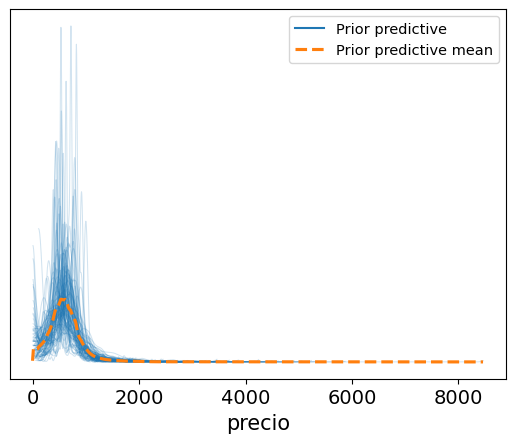

In [14]:
az.plot_ppc(sampleo,group="prior")

Como el prior predictive dio con una cola muy larga, modifico los hiperpriors. (Los sigmas uso valor_referencia/16)

In [15]:
with pm.Model(coords = coords) as modelo_telefonos:
    mu = pm.Normal("mu",mu=valor_referencia/2,sigma=valor_referencia/16,dims="brand")
    sigma = pm.HalfNormal("sigma",sigma=valor_referencia/16,dims="brand")


    precio = pm.Gamma("precio",mu=mu[idx],sigma=sigma[idx],observed=celus_grupos["Price (Dollar)"],dims="brand_flat")

In [16]:
with modelo_telefonos:
    sampleo = pm.sample_prior_predictive(100)

Sampling: [mu, precio, sigma]


<Axes: xlabel='precio'>

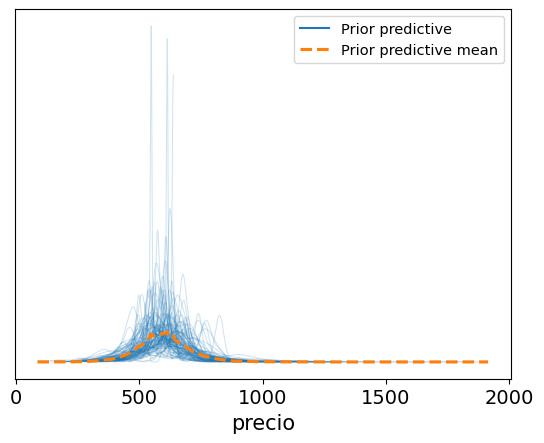

In [66]:
az.plot_ppc(sampleo,group="prior")

Este parece mucho mejor, segun el valor de referencia (1199 usd)

## Ejercicio 3

### a. Todos los aminoacidos juntos

In [17]:
cs_data = pd.read_csv('datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories, "aa_flat":cat_encode.categories[idx]}

with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1) 
    σ = pm.HalfNormal('σ', sigma=2) 
 
    y = pm.Normal('y', mu=μ, sigma=σ, observed=diff) 
    
    idata_juntos= pm.sample(1000)
    idata_juntos.extend(pm.sample_posterior_predictive(idata_juntos))






Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

<Axes: title={'center': 'y'}>

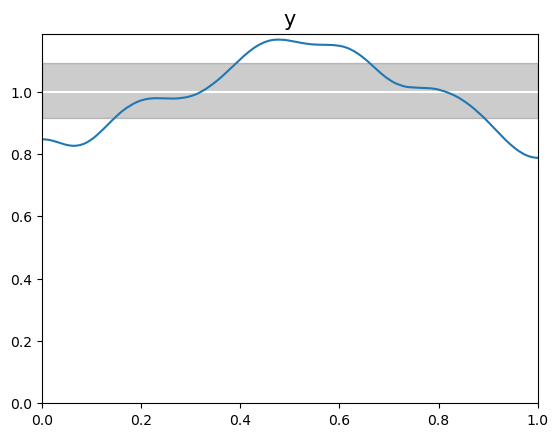

In [18]:
az.plot_bpv(idata_juntos)

### b. Aminoacidos por separados

In [19]:
cs_data = pd.read_csv('datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories, "aa_flat":cat_encode.categories[idx]}

with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff, dims="aa_flat") 
    
    idata_separados= pm.sample(1000)
    idata_separados.extend(pm.sample_posterior_predictive(idata_separados))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

array([[<Axes: title={'center': 'y\nILE'}>,
        <Axes: title={'center': 'y\nTYR'}>,
        <Axes: title={'center': 'y\nSER'}>],
       [<Axes: title={'center': 'y\nALA'}>,
        <Axes: title={'center': 'y\nARG'}>,
        <Axes: title={'center': 'y\nGLY'}>],
       [<Axes: title={'center': 'y\nVAL'}>,
        <Axes: title={'center': 'y\nASP'}>,
        <Axes: title={'center': 'y\nGLU'}>],
       [<Axes: title={'center': 'y\nPHE'}>,
        <Axes: title={'center': 'y\nHIS'}>,
        <Axes: title={'center': 'y\nTHR'}>],
       [<Axes: title={'center': 'y\nMET'}>,
        <Axes: title={'center': 'y\nLYS'}>,
        <Axes: title={'center': 'y\nTRP'}>],
       [<Axes: title={'center': 'y\nASN'}>,
        <Axes: title={'center': 'y\nLEU'}>,
        <Axes: title={'center': 'y\nGLN'}>],
       [<Axes: title={'center': 'y\nPRO'}>, <Axes: >, <Axes: >]],
      dtype=object)

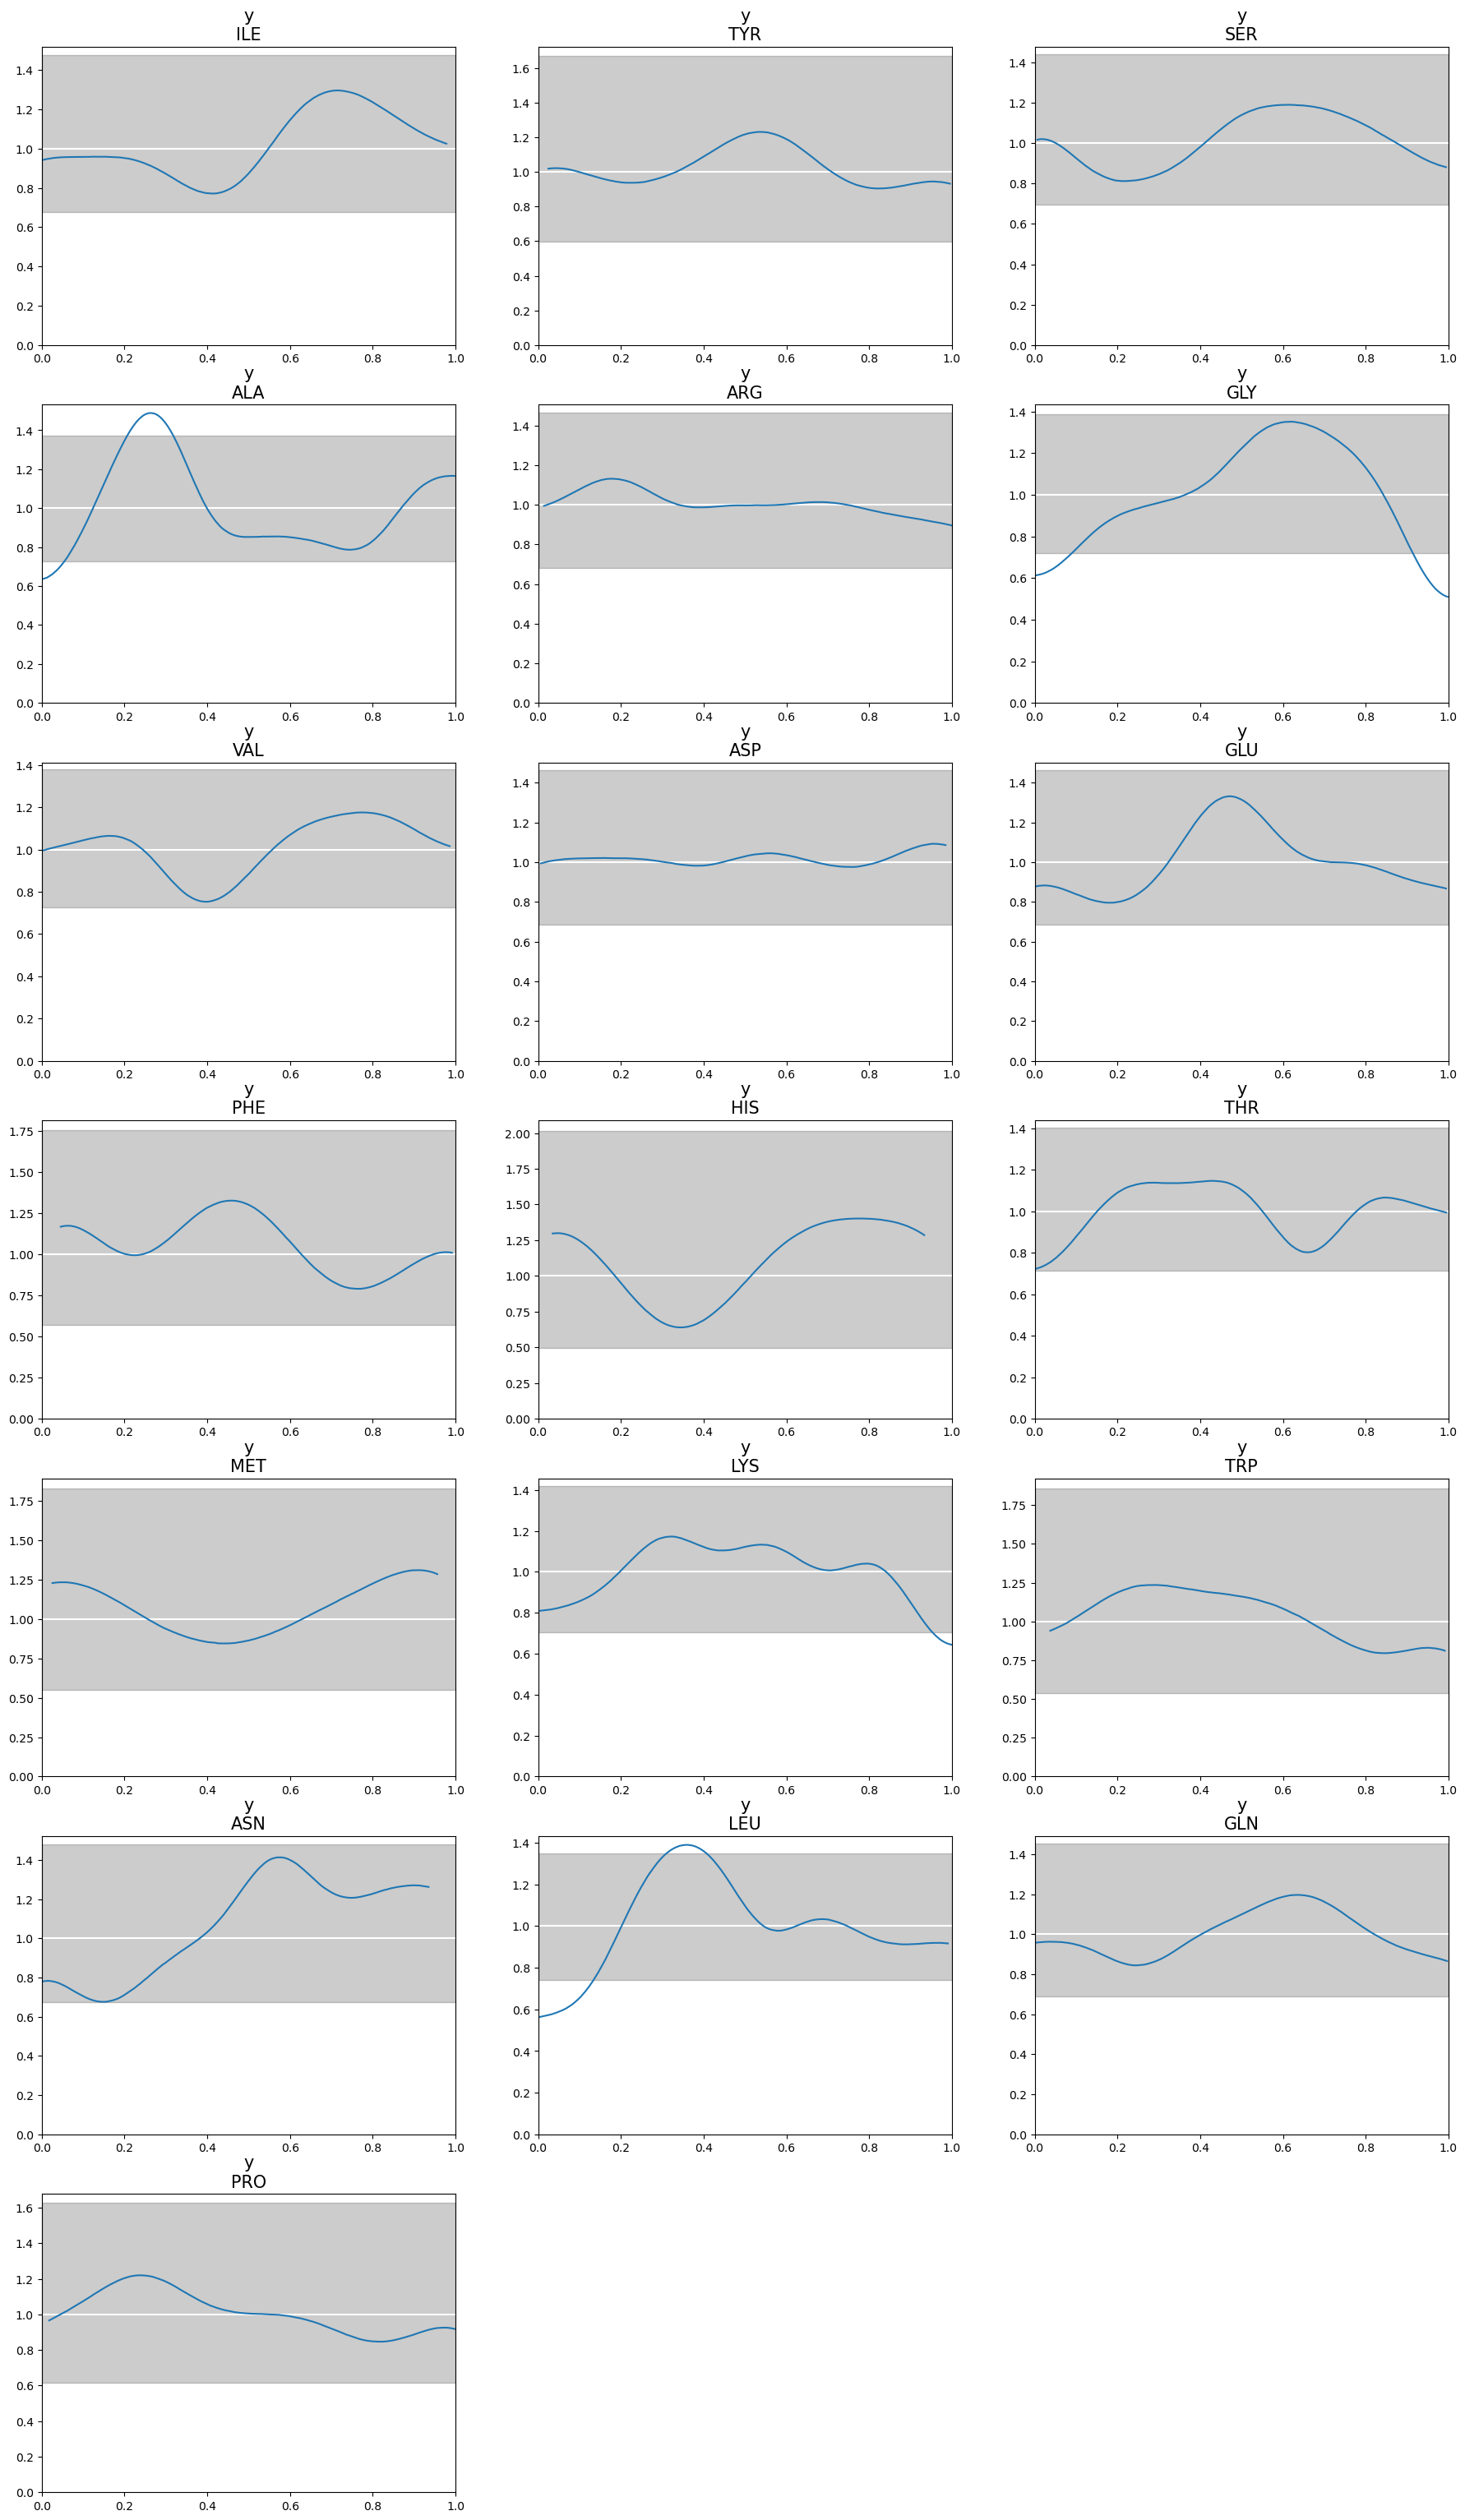

In [20]:
az.plot_bpv(idata_separados,
            coords={"aa_flat": [cat_encode.categories]},
            flatten=[],
            grid = (7,3))

### c) p-value para la desviacion estandar, todos separados

array([[<Axes: title={'center': 'y\nILE'}>,
        <Axes: title={'center': 'y\nTYR'}>,
        <Axes: title={'center': 'y\nSER'}>],
       [<Axes: title={'center': 'y\nALA'}>,
        <Axes: title={'center': 'y\nARG'}>,
        <Axes: title={'center': 'y\nGLY'}>],
       [<Axes: title={'center': 'y\nVAL'}>,
        <Axes: title={'center': 'y\nASP'}>,
        <Axes: title={'center': 'y\nGLU'}>],
       [<Axes: title={'center': 'y\nPHE'}>,
        <Axes: title={'center': 'y\nHIS'}>,
        <Axes: title={'center': 'y\nTHR'}>],
       [<Axes: title={'center': 'y\nMET'}>,
        <Axes: title={'center': 'y\nLYS'}>,
        <Axes: title={'center': 'y\nTRP'}>],
       [<Axes: title={'center': 'y\nASN'}>,
        <Axes: title={'center': 'y\nLEU'}>,
        <Axes: title={'center': 'y\nGLN'}>],
       [<Axes: title={'center': 'y\nPRO'}>, <Axes: >, <Axes: >]],
      dtype=object)

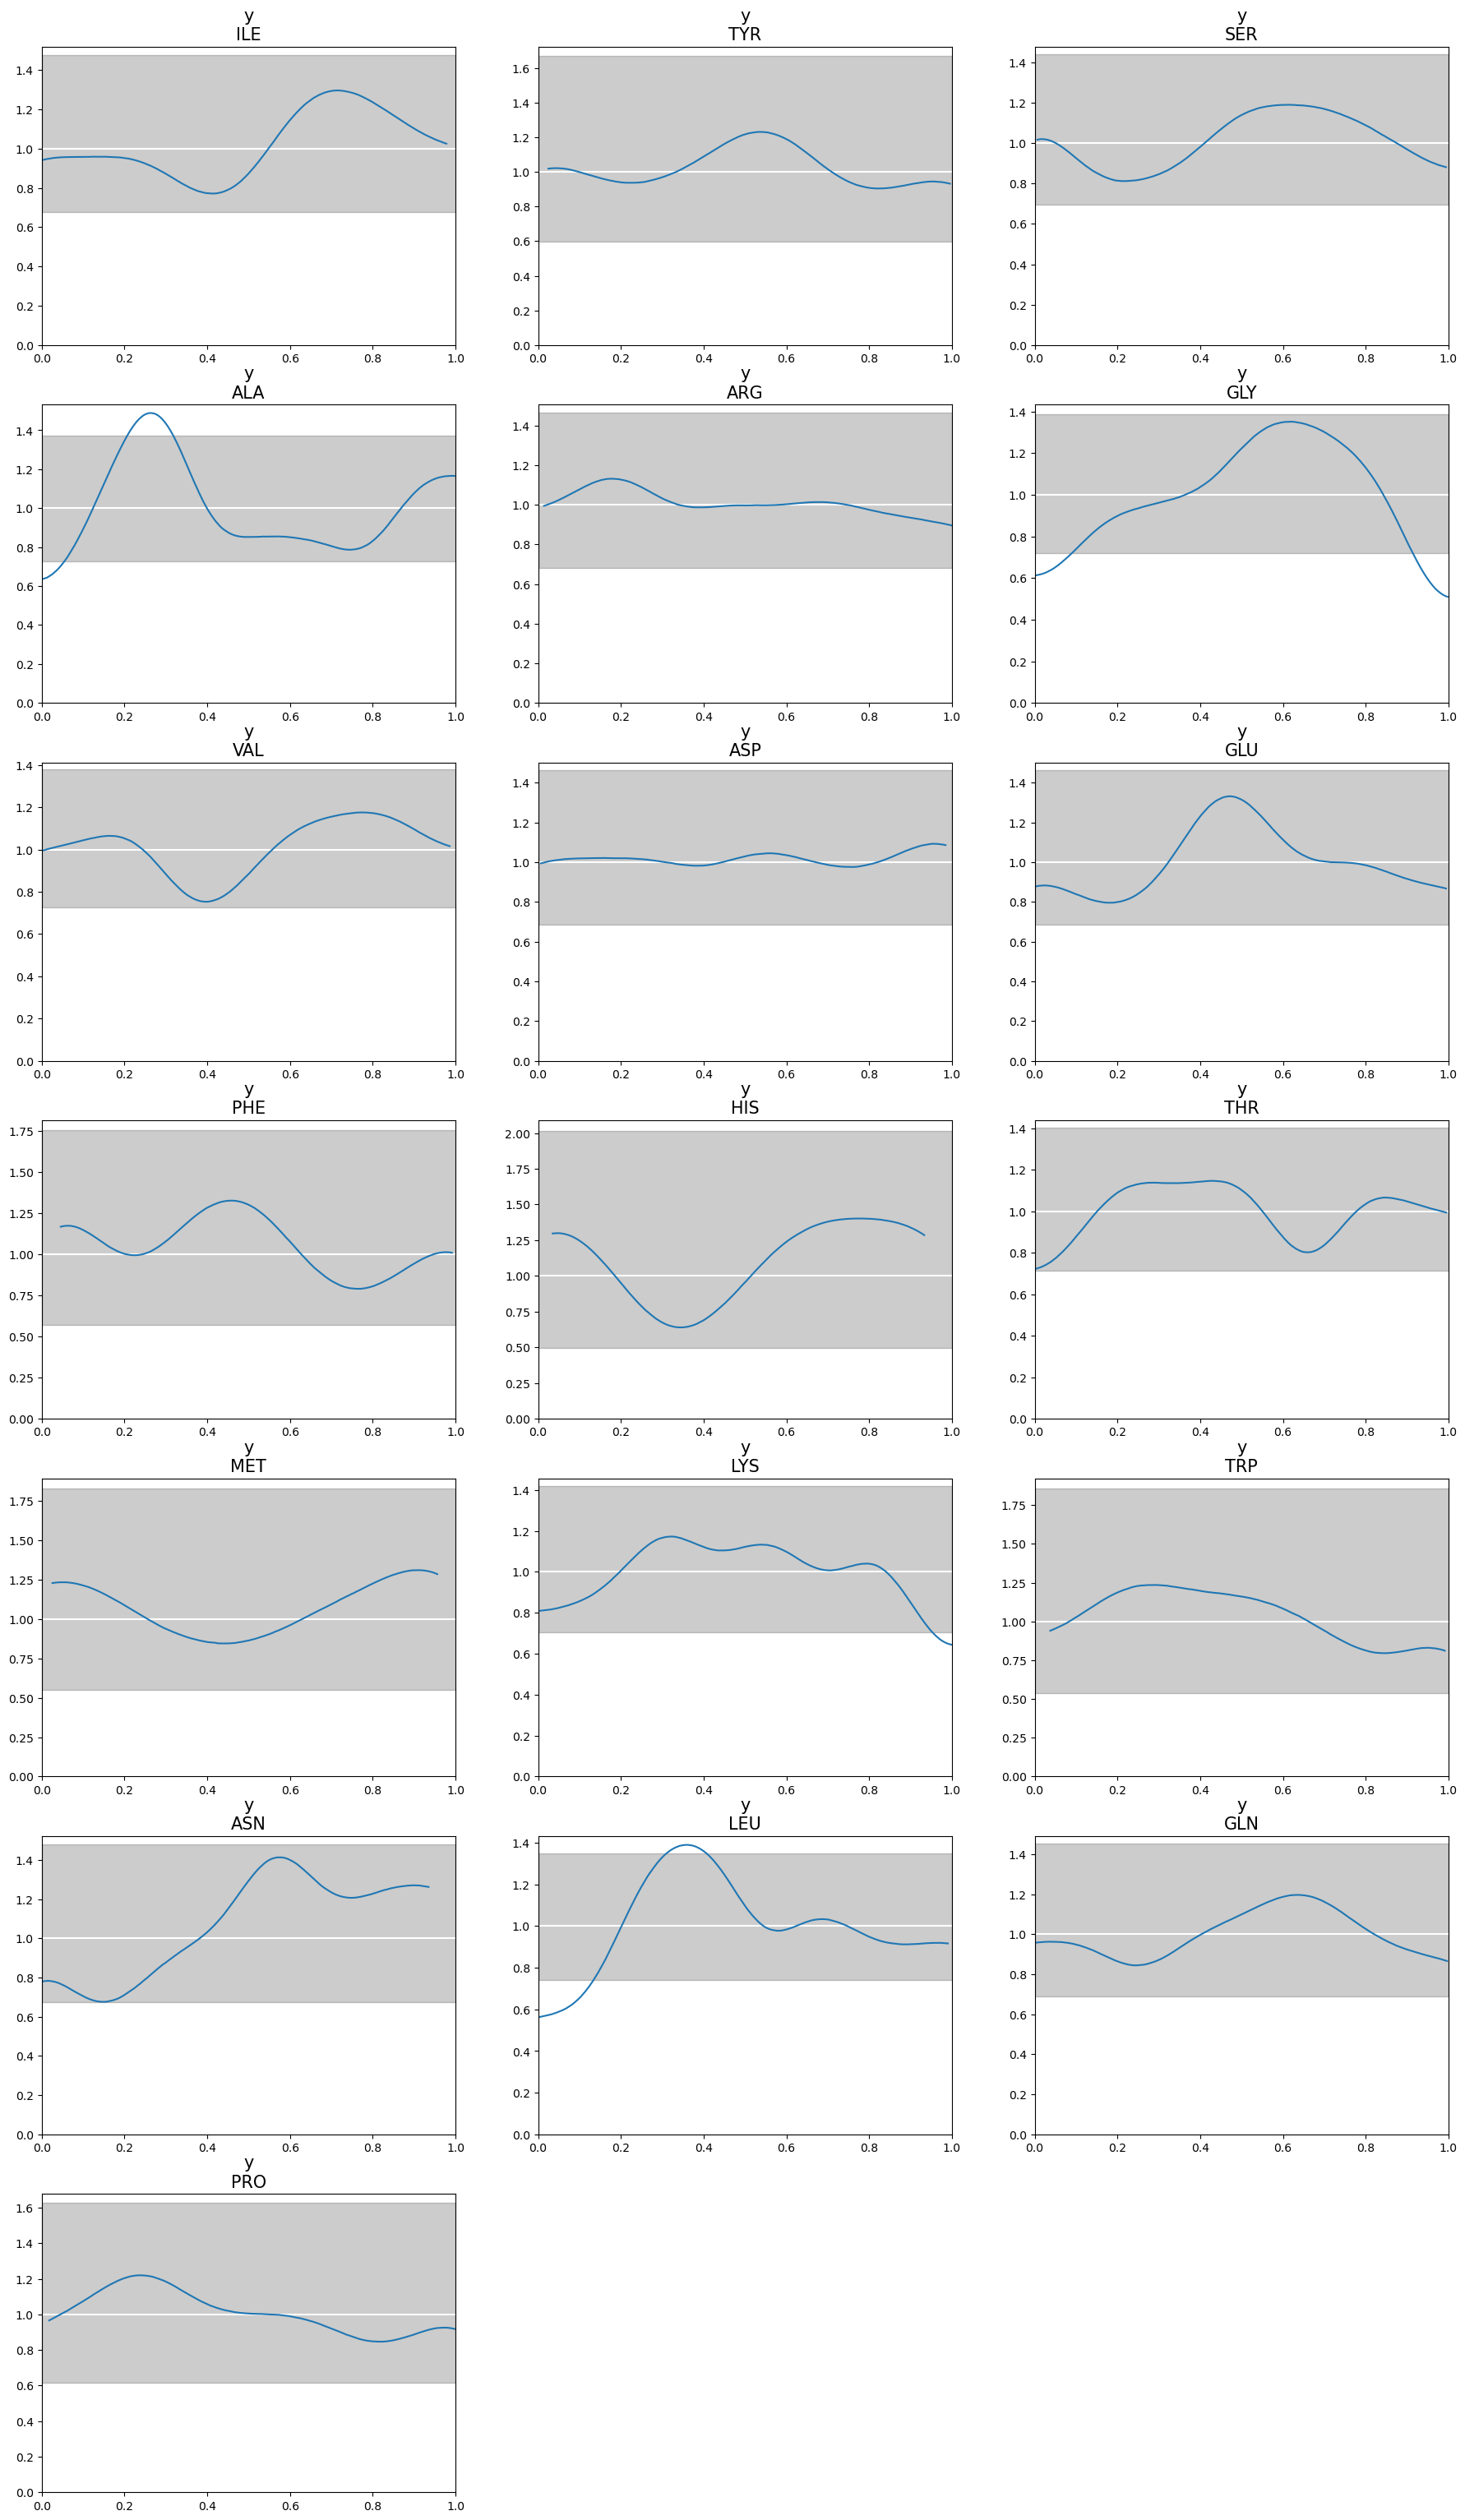

In [21]:
az.plot_bpv(idata_separados,
            t_stat = "std",
            coords={"aa_flat": [cat_encode.categories]},
            flatten=[],
            grid = (7,3))

## Ejercicio 4

Voy a usar como observaciones un sampleo de una Normal(0,5)

(array([ 4.,  6., 23., 22., 53., 49., 19., 15.,  7.,  2.]),
 array([-13.99901342, -11.13484347,  -8.27067352,  -5.40650357,
         -2.54233362,   0.32183633,   3.18600628,   6.05017623,
          8.91434618,  11.77851613,  14.64268608]),
 <BarContainer object of 10 artists>)

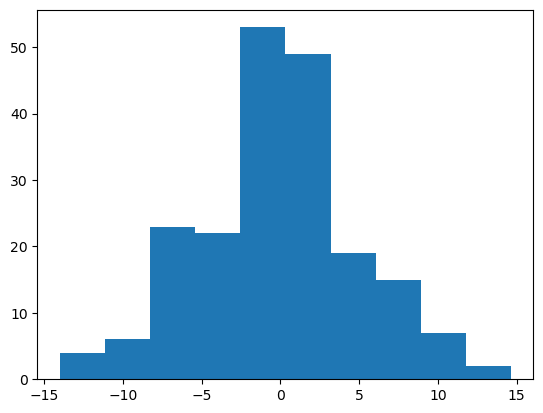

In [24]:
obs = pz.Normal(0,5).rvs(200)
plt.hist(obs)

### Prior mas ancho que distribucion de datos observados

In [25]:
with pm.Model() as modelo_0: # mas ancha que obs
    mu = pm.Normal("mu", mu = 0, sigma = 1)
    sigma = pm.Gamma("sigma",mu = 20,sigma = 1)

    y = pm.Normal("y",mu = mu, sigma = sigma, observed = obs )

    data_ancha = pm.sample(progressbar= False)
    data_ancha.extend(pm.sample_posterior_predictive(data_ancha, progressbar= False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


array(<Axes: title={'center': 'y'}>, dtype=object)

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


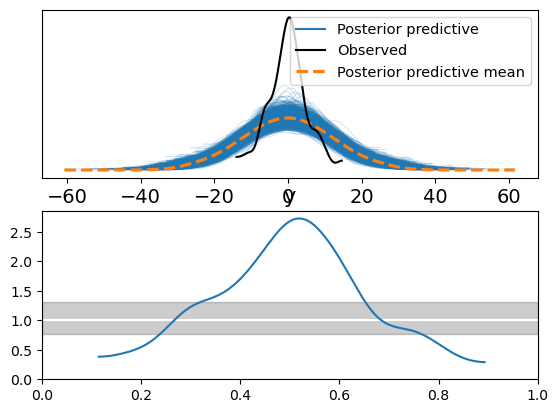

In [26]:
_,ax = plt.subplots(2,1)
az.plot_ppc(data_ancha,ax=ax[0])
az.plot_bpv(data_ancha,ax=ax[1])

Como p-value es P(sim <= obs | y), idealmente deberia ser una uniforme. El eje x del grafico representa los cuantiles  de la distribucion de las observaciones y el eje y, la densidad del p-value. 
Entonces, si la distribucion de mis datos simulados (posterior_predictive) es mas ancha que la de los datos observados, para los valores en el "centro" de la distribucion (en este caso, el pico de mi normal), p es mayor que 1 (los valores simulados son menores que los observados) y para las colas es menor que 1 (la prediccion las sobreestima, sim > obs).

### Prior mas angosto que la distribucion de los datos observados

In [27]:
with pm.Model() as modelo_1: # Mas angosta que obs
    mu = pm.Normal("mu", mu = 0, sigma = 0.1)
    sigma = pm.HalfNormal("sigma",sigma = 0.1)

    y = pm.Normal("y",mu = mu, sigma = sigma, observed = obs )

    data_angosta = pm.sample(progressbar= False)
    data_angosta.extend(pm.sample_posterior_predictive(data_angosta, progressbar= False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


array(<Axes: title={'center': 'y'}>, dtype=object)

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


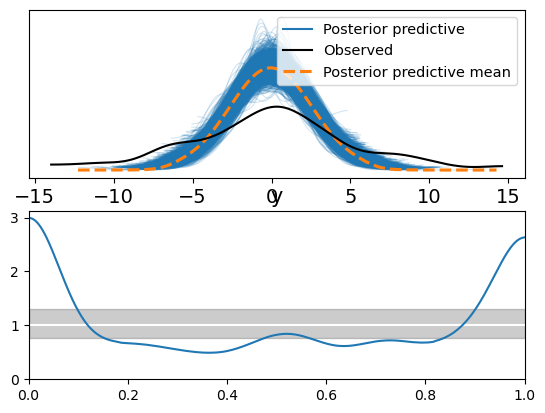

In [28]:
_,ax = plt.subplots(2,1)
az.plot_ppc(data_angosta,ax=ax[0])
az.plot_bpv(data_angosta,ax=ax[1])

En este caso se ve lo contrario del anterior: mi prediccion a posteriori subestima las colas, haciendo que la densidad de p-value sea mayor que 1; y sobreestima el pico de la distribucion, haciendo que la densidad del p-value sea menor que 1

### Prior con media desplazada

In [29]:
with pm.Model() as modelo_2: 
    mu = pm.Normal("mu", mu = 5, sigma = 0.1)
    sigma = pm.HalfNormal("sigma",sigma = 5)

    y = pm.Normal("y",mu = mu, sigma = sigma, observed = obs )

    data_desplazada = pm.sample(progressbar= False)
    data_desplazada.extend(pm.sample_posterior_predictive(data_desplazada, progressbar= False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


array(<Axes: title={'center': 'y'}>, dtype=object)

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


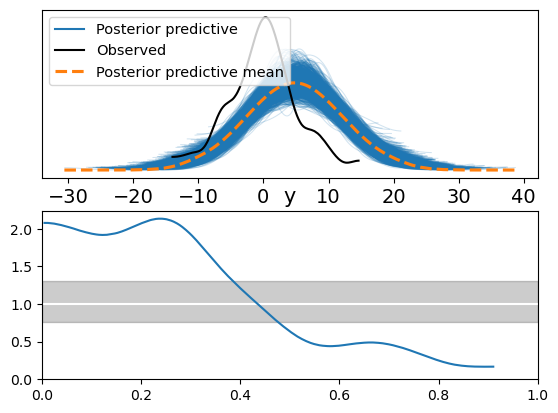

In [30]:
_,ax = plt.subplots(2,1)
az.plot_ppc(data_desplazada,ax=ax[0])
az.plot_bpv(data_desplazada,ax=ax[1])

Al desplazar el prior, la distribucion del p-value queda "linealizada": donde la distribucion subestima valores (y<5, en el grafico del p-value coincide con los cuantiles <0.4) la densidad del p-value es mayor que 1; donde sobreestima es menor que 1. (En todo el analisis hablo de mayor o menor que 1, pero me refiero a que escapa del intervalo esperado).

### Prior igual a la distribucion

<Axes: >

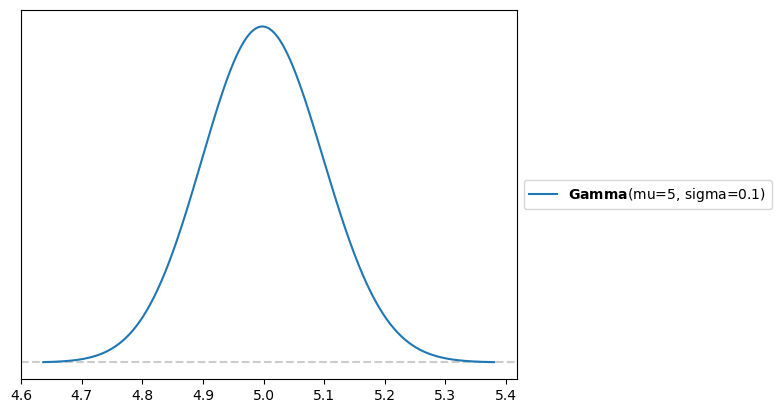

In [33]:
pz.Gamma(mu=5,sigma=0.1).plot_pdf()

In [35]:
with pm.Model() as modelo_3: # Mas angosta que obs
    mu = pm.Normal("mu", mu = 0, sigma = 0.1)
    sigma = pm.Gamma("sigma",mu=5,sigma=0.1)

    y = pm.Normal("y",mu = mu, sigma = sigma, observed = obs )

    data_igual = pm.sample(progressbar= False)
    data_igual.extend(pm.sample_posterior_predictive(data_igual, progressbar= False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


array(<Axes: title={'center': 'y'}>, dtype=object)

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


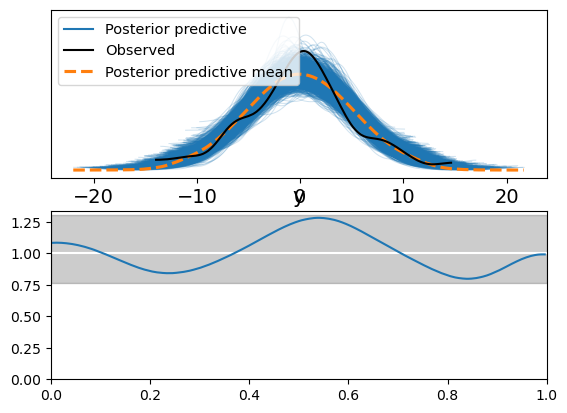

In [36]:
_,ax = plt.subplots(2,1)
az.plot_ppc(data_igual,ax=ax[0])
az.plot_bpv(data_igual,ax=ax[1])

Usando priors que maximicen valores muy cercanos a los parametros verdaderos de los datos, nos queda una distribucion del p-value dentro del intervalo gris, que es el area donde se considera, segun el tamanio de los datos, que es aceptable.